<center><h1>Template for multilevel analysis</h1></center>

In [1]:
library(lme4)
library(lmerTest)
library(nlme)
library(ggplot2)
library(grid)
library(gridExtra)
library(lattice)
library(plyr)
library(MASS)
library(stats4)
library(dplyr)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<h2>Load data</h2>

In [2]:
rm(list = ls())
mydata <- read.table("data.csv", header=TRUE, sep=",")
mydata$choice <- as.factor(mydata$choice)
mydata$logdt <- log(1+mydata$dt)
mydata$wtpcert <- mydata$wtp - mydata$certainty # this variable indicates how much wtp exceeds the certain payment

# sessions: ebld7meg, brtqjddt, 6zu2rqqa, eziaa6hq

In [3]:
# does someone need to be excluded? if so, then do this
#mydata <- subset(mydata, code != "xxxxxx")

# make sure there are NAs where the decision times are too slow (thousands of seconds)
#mydata$dt <- ifelse(mydata$dt > 60, "NA", mydata$dt)

In [3]:
unique(mydata$code[mydata$slc_lot>7])

[1] 12sc0g5v 1qbnwx3l 36ouqzzd 52j7762b bjfz28ad d31s1n66 hh7kzemh hx9ehppu
 [9] io49s2w4 jpuryirm jpwrvoov jurpiifj knx8vg7c l0kaow09 o69ey5fu ouiw6pd9
[17] skhtyere u4qbd47b uhztk9co vjrwmz25 x3t78y9i z3d6txou
72 Levels: 0m74d76z 0qdzvx7e 12sc0g5v 1mnjeuu1 1qbnwx3l 29qda7ah ... z7pvqin0

In [3]:
# make a copy of mydata where less than 300ms and more than 10s rounds are rejected
mydata2 <- subset(mydata, dt>.3 & dt<10)

# additionally subjects with slc_lot>7 rejected
mydata3 <- subset(mydata2, slc_lot<=7)


<h2>Summary statistics</h2>

In [7]:
# the plyr package has really useful summarising functions
ddply(mydata, c("treatment"), summarise, 
      N = length(choice)/216,
      'mean DT' = mean(dt, na.rm=T),
      'sd DT' = sd(dt, na.rm=T),
      'mean dec. mode' = mean(decmode),
      'mean accuracy' = mean(accuracy))

treatment,N,mean DT,sd DT,mean dec. mode,mean accuracy
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,36,2.938477,5.320870,3.666667,0.6579218
E,36,3.037160,4.251024,4.361111,0.6464884


<h2>Correlation matrix for psychometric measurements</h2>

In [11]:
cordf <- mydata %>% select(ref,int,nfc,fi,bnt)
cor(cordf)

,ref,int,nfc,fi,bnt
ref,1.0000000,-0.88858377,0.1150721514,-0.18074574,0.5277104515
int,-0.8885838,1.00000000,-0.0361085404,0.26342536,-0.3554411973
nfc,0.1150722,-0.03610854,1.0000000000,-0.06474535,0.0007635697
fi,-0.1807457,0.26342536,-0.0647453490,1.00000000,-0.0978282379
bnt,0.5277105,-0.35544120,0.0007635697,-0.09782824,1.0000000000


<center><h1 style="color: blue;">* * * Basic LMs for psychometric variables * * *</h1></center>

<p>Accuracy correlates with reflectiveness when controlling interactions between ref and int</p>

In [50]:
summary(lm(accuracy ~ scale(ref)*scale(int), subset(mydata, round==1)))
summary(lm(accuracy ~ scale(nfc)*scale(fi),  subset(mydata, round==1)))


Call:
lm(formula = accuracy ~ scale(ref) * scale(int), data = subset(mydata, 
    round == 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28922 -0.10573  0.01186  0.10184  0.26822 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.63698    0.02277  27.976   <2e-16 ***
scale(ref)             0.08404    0.03653   2.301   0.0245 *  
scale(int)             0.03718    0.03596   1.034   0.3048    
scale(ref):scale(int) -0.01737    0.01917  -0.906   0.3681    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1304 on 68 degrees of freedom
Multiple R-squared:  0.1798,	Adjusted R-squared:  0.1437 
F-statistic:  4.97 on 3 and 68 DF,  p-value: 0.003539



Call:
lm(formula = accuracy ~ scale(nfc) * scale(fi), data = subset(mydata, 
    round == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3055 -0.1145  0.0205  0.1075  0.2348 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.652368   0.016881  38.645   <2e-16 ***
scale(nfc)           -0.006592   0.017061  -0.386    0.700    
scale(fi)             0.016344   0.017236   0.948    0.346    
scale(nfc):scale(fi)  0.002553   0.020188   0.126    0.900    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1428 on 68 degrees of freedom
Multiple R-squared:  0.01611,	Adjusted R-squared:  -0.02729 
F-statistic: 0.3713 on 3 and 68 DF,  p-value: 0.774


<p>Decision mode does not differ between treatments</p>

In [51]:
summary(lm(decmode ~ treatment, subset(mydata, round==1)))


Call:
lm(formula = decmode ~ treatment, data = subset(mydata, round == 
    1))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6667 -1.4375 -0.0139  1.3333  3.3333 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.6667     0.2819  13.005   <2e-16 ***
treatmentE    0.6944     0.3987   1.742    0.086 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.692 on 70 degrees of freedom
Multiple R-squared:  0.04154,	Adjusted R-squared:  0.02784 
F-statistic: 3.034 on 1 and 70 DF,  p-value: 0.08595


<p>Decision mode correlates only with FI. For NFC and FI we must look into interaction effects</p>

In [52]:
summary(lm(decmode ~ scale(ref)+scale(int), subset(mydata, round==1)))
summary(lm(decmode ~ scale(nfc)*scale(fi), subset(mydata, round==1)))
summary(lm(decmode ~ scale(bnt), subset(mydata, round==1)))


Call:
lm(formula = decmode ~ scale(ref) + scale(int), data = subset(mydata, 
    round == 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.03689 -1.27980 -0.02978  1.02797  3.02708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.013889   0.205074  19.573   <2e-16 ***
scale(ref)   0.007562   0.450200   0.017    0.987    
scale(int)  -0.020898   0.450200  -0.046    0.963    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.74 on 69 degrees of freedom
Multiple R-squared:  0.0002632,	Adjusted R-squared:  -0.02871 
F-statistic: 0.009083 on 2 and 69 DF,  p-value: 0.991



Call:
lm(formula = decmode ~ scale(nfc) * scale(fi), data = subset(mydata, 
    round == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1420 -1.3533  0.0448  1.4616  3.4666 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.0211     0.2004  20.070   <2e-16 ***
scale(nfc)             0.1601     0.2025   0.790   0.4320    
scale(fi)              0.4257     0.2046   2.081   0.0412 *  
scale(nfc):scale(fi)   0.1136     0.2396   0.474   0.6368    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.695 on 68 degrees of freedom
Multiple R-squared:  0.06501,	Adjusted R-squared:  0.02377 
F-statistic: 1.576 on 3 and 68 DF,  p-value: 0.2032



Call:
lm(formula = decmode ~ scale(bnt), data = subset(mydata, round == 
    1))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.99956 -1.39696 -0.07326  1.29524  3.14784 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.0139     0.2026  19.809   <2e-16 ***
scale(bnt)   -0.1699     0.2041  -0.833    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.719 on 70 degrees of freedom
Multiple R-squared:  0.009806,	Adjusted R-squared:  -0.00434 
F-statistic: 0.6932 on 1 and 70 DF,  p-value: 0.4079


<p>Decision mode vs. psychometrics scatter plots</p>

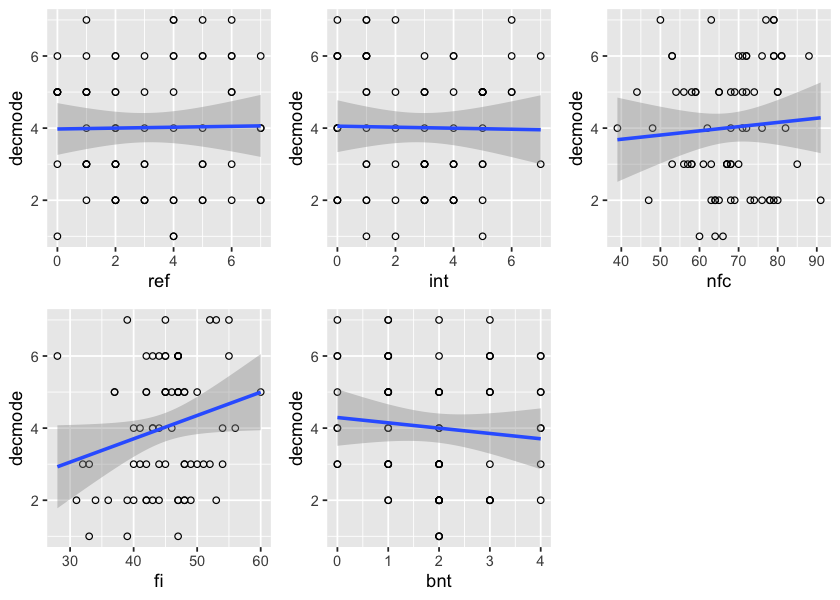

In [53]:
options(repr.plot.width=7, repr.plot.height=5)


gpl1 <- ggplot(subset(mydata, round==1), aes(x=ref, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl2 <- ggplot(subset(mydata, round==1), aes(x=int, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl3 <- ggplot(subset(mydata, round==1), aes(x=nfc, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl4 <- ggplot(subset(mydata, round==1), aes(x=fi,  y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl5 <- ggplot(subset(mydata, round==1), aes(x=bnt, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)


grid.arrange(gpl1, gpl2, gpl3, gpl4, gpl5, nrow = 2)


<center><h1 style="color: blue;">* * * Decision time distributions * * *</h1></center>

<p>DT ecdf</p>

Warning message:
“Removed 520 rows containing non-finite values (stat_ecdf).”

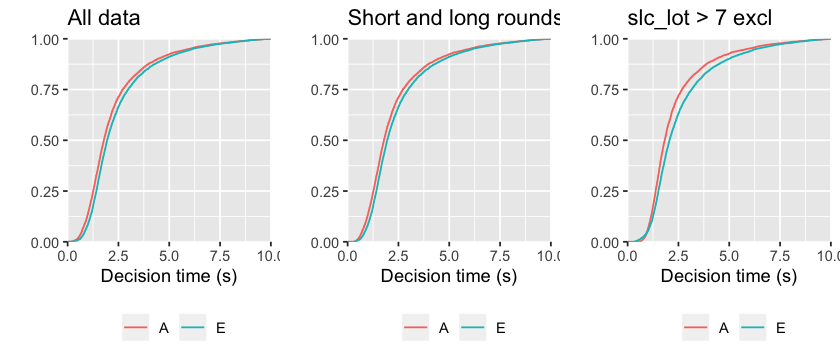

In [4]:
options(repr.plot.width=7, repr.plot.height=3)


ecdf <- ggplot(subset(mydata, (treatment=="A" | treatment=="E")), aes(dt, colour=treatment)) + 
        stat_ecdf(geom = "step") + 
        labs(title = "All data", y = "", x = "Decision time (s)") +
        scale_x_continuous(expand= c(0, 0), limits = c(0, 10)) +
        scale_y_continuous(expand = c(0, 0)) + 
        theme(legend.position="bottom", legend.title=element_blank())

ecdf2 <- ggplot(subset(mydata2, (treatment=="A" | treatment=="E")), aes(dt, colour=treatment)) + 
        stat_ecdf(geom = "step") + 
        labs(title = "Short and long rounds excl", y = "", x = "Decision time (s)") +
        scale_x_continuous(expand= c(0, 0), limits = c(0, 10)) +
        scale_y_continuous(expand = c(0, 0)) + 
        theme(legend.position="bottom", legend.title=element_blank())

ecdf3 <- ggplot(subset(mydata3, (treatment=="A" | treatment=="E")), aes(dt, colour=treatment)) + 
        stat_ecdf(geom = "step") + 
        labs(title = "slc_lot > 7 excl", y = "", x = "Decision time (s)") +
        scale_x_continuous(expand= c(0, 0), limits = c(0, 10)) +
        scale_y_continuous(expand = c(0, 0)) + 
        theme(legend.position="bottom", legend.title=element_blank())



grid.arrange(ecdf, ecdf2, ecdf3, nrow=1)

<p>DT distributions differ at the aggregate level</p>

In [5]:
ks.test(mydata$dt[mydata$treatment=="A"], mydata$dt[mydata$treatment=="E"], alternative="greater")

ks.test(mydata2$dt[mydata2$treatment=="A"], mydata2$dt[mydata2$treatment=="E"], alternative="greater")

ks.test(mydata2$dt[mydata2$treatment=="A"], mydata2$dt[mydata3$treatment=="E"], alternative="greater")

Warning message in ks.test(mydata$dt[mydata$treatment == "A"], mydata$dt[mydata$treatment == :
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  mydata$dt[mydata$treatment == "A"] and mydata$dt[mydata$treatment == "E"]
D^+ = 0.075508, p-value < 2.2e-16
alternative hypothesis: the CDF of x lies above that of y


Warning message in ks.test(mydata2$dt[mydata2$treatment == "A"], mydata2$dt[mydata2$treatment == :
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  mydata2$dt[mydata2$treatment == "A"] and mydata2$dt[mydata2$treatment == "E"]
D^+ = 0.075991, p-value < 2.2e-16
alternative hypothesis: the CDF of x lies above that of y


Warning message in ks.test(mydata2$dt[mydata2$treatment == "A"], mydata2$dt[mydata3$treatment == :
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  mydata2$dt[mydata2$treatment == "A"] and mydata2$dt[mydata3$treatment == "E"]
D^+ = 0.051025, p-value = 1.161e-09
alternative hypothesis: the CDF of x lies above that of y


<h2>Simple linear regression with averaged DTs: DT is decreasing in decision mode</h2>
<p>Determine the average DT for each participant, add this as a column in the data frame, and use a linear model without random effects</p>

In [8]:
aggrdata <- mydata %>% group_by(code) %>% summarise(meandt = mean(dt, na.rm=T))
mydata$meandt <- rep(aggrdata$meandt, each=216)

In [9]:
summary(lm(meandt ~ decmode, mydata))


Call:
lm(formula = meandt ~ decmode, data = mydata)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1344 -0.8222 -0.2512  0.5170  4.4861 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.077356   0.026228 117.330  < 2e-16 ***
decmode     -0.022346   0.006015  -3.715 0.000204 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.278 on 15550 degrees of freedom
Multiple R-squared:  0.0008868,	Adjusted R-squared:  0.0008226 
F-statistic:  13.8 on 1 and 15550 DF,  p-value: 0.0002038


<center><h1 style="color: blue;">* * * Decision time GLMMs * * *</h1></center>

<p>This uses a GLMM and recognises different variances in DTs over the subjects. The distribution family we use is Gamma distribution in accordance with Lo & Andrews (2015). The psychometric variables or decision mode do not have any impact on decision times.</p>

In [9]:
summary(glmer(dt ~ (scale(ref)*scale(int) + scale(nfc)*scale(fi) + scale(bnt)):treatment + (1|code), mydata, family = Gamma(link = "identity")))

summary(glmer(dt ~ decmode + (1|code), mydata, family = Gamma(link = "identity")))

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00214141 (tol = 0.001, component 1)”
Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: 
dt ~ (scale(ref) * scale(int) + scale(nfc) * scale(fi) + scale(bnt)):treatment +  
    (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 59096.6  59226.7 -29531.3  59062.6    15531 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.726 -0.350 -0.191  0.063 48.385 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 2.631    1.622   
 Residual             1.894    1.376   
Number of obs: 15548, groups:  code, 72

Fixed effects:
                                  Estimate Std. Error t value Pr(>|z|)    
(Intercept)                       3.134413   0.216740  14.462   <2e-16 ***
scale(ref):treatmentA             0.995526   0.561256   1.774   0.0761 .  
scale(ref):treatmentE             0.483897   0.538895   0.898   0.3692    
scale(int):treatmentA             0.699780   0.560992   1.247   0.2123    


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ decmode + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 59080.9  59111.6 -29536.5  59072.9    15544 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.726 -0.350 -0.191  0.064 48.594 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 3.040    1.744   
 Residual             1.895    1.377   
Number of obs: 15548, groups:  code, 72

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.47883    0.38223   6.485 8.86e-11 ***
decmode      0.12894    0.08768   1.471    0.141    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
decmode -0.920

<p>This simple GLMM shows that DT is decreasing over time as expected. We use log(1+dt) and normal family instead of raw dt and Gamma family because glmer somehow produces errors when round is an independent regressor.</p>

In [61]:
# summary(glmer(dt ~ round + (1|code), mydata, family = Gamma(link = "identity")))
mydata$logdt <- log(1+mydata$dt)
summary(lmer(logdt ~ round + (1|code), mydata))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logdt ~ round + (1 | code)
   Data: mydata

REML criterion at convergence: 19927.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8002 -0.6048 -0.1956  0.3499  9.6846 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.0577   0.2402  
 Residual             0.2067   0.4546  
Number of obs: 15548, groups:  code, 72

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  1.341e+00  2.924e-02  7.819e+01   45.85   <2e-16 ***
round       -1.412e-03  5.847e-05  1.548e+04  -24.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr)
round -0.217

<p>DTs are longer in lottery choices but only in treatment E. If we exclude the 22 subjects, then DTs are longer in lottery choices in both treatments.</p>

In [7]:
summary(glmer(dt ~ choice + (1|code), family = Gamma(link = "identity"), subset(mydata, treatment=="A")))
summary(glmer(dt ~ choice + (1|code), family = Gamma(link = "identity"), subset(mydata, treatment=="E")))

summary(glmer(dt ~ choice + (1|code), family = Gamma(link = "identity"), subset(mydata3, treatment=="A")))
summary(glmer(dt ~ choice + (1|code), family = Gamma(link = "identity"), subset(mydata3, treatment=="E")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ choice + (1 | code)
   Data: subset(mydata, treatment == "A")

     AIC      BIC   logLik deviance df.resid 
 29545.4  29573.2 -14768.7  29537.4     7770 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.621 -0.309 -0.168  0.044 41.686 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 4.252    2.062   
 Residual             2.553    1.598   
Number of obs: 7774, groups:  code, 36

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.92961    0.21634  13.542   <2e-16 ***
choice1      0.02950    0.03894   0.758    0.449    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
choice1 -0.086

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ choice + (1 | code)
   Data: subset(mydata, treatment == "E")

     AIC      BIC   logLik deviance df.resid 
 29455.8  29483.6 -14723.9  29447.8     7770 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9030 -0.4243 -0.2299  0.0935 31.3806 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 2.013    1.419   
 Residual             1.226    1.107   
Number of obs: 7774, groups:  code, 36

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.96652    0.21374  13.879  < 2e-16 ***
choice1      0.18016    0.03796   4.746 2.07e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
choice1 -0.077

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ choice + (1 | code)
   Data: subset(mydata3, treatment == "A")

     AIC      BIC   logLik deviance df.resid 
 14345.3  14371.2  -7168.6  14337.3     4804 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3931 -0.6141 -0.2920  0.2547  8.9684 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.1119   0.3345  
 Residual             0.3740   0.6116  
Number of obs: 4808, groups:  code, 23

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.30526    0.10834  21.278  < 2e-16 ***
choice1      0.16982    0.03339   5.086 3.66e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
choice1 -0.123

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ choice + (1 | code)
   Data: subset(mydata3, treatment == "E")

     AIC      BIC   logLik deviance df.resid 
 17605.7  17632.2  -8798.9  17597.7     5613 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5929 -0.6471 -0.2946  0.3112  6.8918 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.2344   0.4841  
 Residual             0.3375   0.5809  
Number of obs: 5617, groups:  code, 27

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.61449    0.15465  16.906  < 2e-16 ***
choice1      0.15852    0.03184   4.979 6.39e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
choice1 -0.084

<p>DT's are longer in lottery choices and increase in WTP, but this relationship is less intense with lottery choices. This is again done with the logarithmic DT, as the glmer function has some difficulties with the intraction when the Gamma family is used. Holds when the 22 subjects are excluded.</p>

In [8]:
# This produces errors:
#summary(glmer(dt ~ scale(wtpcert)*choice + (1|code), family = Gamma(link = "identity"), mydata))

summary(lmer(logdt ~ scale(wtpcert)*choice + (1|code), mydata))
summary(lmer(logdt ~ scale(wtpcert)*choice + (1|code), mydata3))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logdt ~ scale(wtpcert) * choice + (1 | code)
   Data: mydata

REML criterion at convergence: 20452.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0844 -0.6014 -0.2005  0.3638  9.1834 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.0585   0.2419  
 Residual             0.2137   0.4623  
Number of obs: 15548, groups:  code, 72

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             1.186e+00  2.904e-02  7.393e+01  40.844  < 2e-16 ***
scale(wtpcert)          3.029e-02  5.444e-03  1.554e+04   5.564 2.68e-08 ***
choice1                 2.062e-02  8.472e-03  1.553e+04   2.434    0.015 *  
scale(wtpcert):choice1 -5.205e-02  8.379e-03  1.551e+04  -6.213 5.34e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scl(w) 

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logdt ~ scale(wtpcert) * choice + (1 | code)
   Data: mydata3

REML criterion at convergence: 7772.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2130 -0.6875 -0.1990  0.4844  4.3990 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.02971  0.1724  
 Residual             0.12078  0.3475  
Number of obs: 10425, groups:  code, 50

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             1.160e+00  2.489e-02  5.111e+01  46.601  < 2e-16 ***
scale(wtpcert)          3.281e-02  4.908e-03  1.042e+04   6.686 2.41e-11 ***
choice1                 5.461e-02  8.361e-03  1.042e+04   6.531 6.84e-11 ***
scale(wtpcert):choice1 -5.777e-02  8.252e-03  1.040e+04  -7.001 2.70e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scl(w) 

<center><h1 style="color: blue;">* * * Choice GLMMs * * *</h1></center>

<p>Choice probabilities are not affected by the psychometric variables nor decision mode, except FI in treatment E where higher FI increases probability to choose lottery.</p>

In [10]:
summary(glmer(choice ~ (scale(ref)*scale(int) + scale(nfc)*scale(fi) + scale(bnt)):treatment + (1|code), mydata, family=binomial(link = "logit")))
summary(glmer(choice ~ (scale(ref)*scale(int) + scale(nfc)*scale(fi) + scale(bnt)):treatment + (1|code), mydata3, family=binomial(link = "logit")))



Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ (scale(ref) * scale(int) + scale(nfc) * scale(fi) +  
    scale(bnt)):treatment + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 19860.9  19983.3  -9914.5  19828.9    15536 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1730 -0.9419 -0.4145  0.9261  2.9427 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.5261   0.7254  
Number of obs: 15552, groups:  code, 72

Fixed effects:
                                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)                      -0.17448    0.13633  -1.280   0.2006  
scale(ref):treatmentA             0.35420    0.35597   0.995   0.3197  
scale(ref):treatmentE             0.36271    0.34203   1.060   0.2889  
scale(int):treatmentA             0.41340    0.35552   1.163   0.2449  
scale(int):treatmentE             0.14675    0


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ (scale(ref) * scale(int) + scale(nfc) * scale(fi) +  
    scale(bnt)):treatment + (1 | code)
   Data: mydata3

     AIC      BIC   logLik deviance df.resid 
 13036.5  13152.6  -6502.3  13004.5    10409 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7090 -0.7567 -0.4320  0.8806  3.0063 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.5144   0.7172  
Number of obs: 10425, groups:  code, 50

Fixed effects:
                                  Estimate Std. Error z value Pr(>|z|)   
(Intercept)                      -0.479493   0.184640  -2.597  0.00941 **
scale(ref):treatmentA            -0.093878   0.473859  -0.198  0.84296   
scale(ref):treatmentE             0.709980   0.457406   1.552  0.12062   
scale(int):treatmentA            -0.009502   0.434420  -0.022  0.98255   
scale(int):treatmentE             0

<p>Choice probabilities and WTP: These have a significant relationship in a GLMM and this relationship is also moderated by reflectiveness and NFC.</p>

In [11]:
summary(glmer(choice ~ scale(wtpcert)*(scale(ref)+scale(nfc)+scale(bnt)) + (1|code), mydata, family=binomial(link = "logit")))
summary(glmer(choice ~ scale(wtpcert)*(scale(ref)+scale(nfc)+scale(bnt)) + (1|code), mydata3, family=binomial(link = "logit")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ scale(wtpcert) * (scale(ref) + scale(nfc) + scale(bnt)) +  
    (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 17508.0  17576.9  -8745.0  17490.0    15543 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-16.4136  -0.7436  -0.2125   0.7424  14.5825 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.8811   0.9387  
Number of obs: 15552, groups:  code, 72

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.15873    0.11228  -1.414 0.157450    
scale(wtpcert)             1.11138    0.02745  40.490  < 2e-16 ***
scale(ref)                 0.06980    0.13330   0.524 0.600526    
scale(nfc)                 0.05295    0.11328   0.467 0.640213    
scale(bnt)                 0.03213    0.13257   0.242 0.808521    
scale(wtpcer

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ scale(wtpcert) * (scale(ref) + scale(nfc) + scale(bnt)) +  
    (1 | code)
   Data: mydata3

     AIC      BIC   logLik deviance df.resid 
 10522.4  10587.6  -5252.2  10504.4    10416 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-28.0989  -0.6195  -0.2093   0.6319  29.8355 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 1.235    1.111   
Number of obs: 10425, groups:  code, 50

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.44488    0.15924  -2.794  0.00521 ** 
scale(wtpcert)             1.59773    0.04081  39.149  < 2e-16 ***
scale(ref)                 0.16014    0.20261   0.790  0.42930    
scale(nfc)                 0.03035    0.16194   0.187  0.85131    
scale(bnt)                -0.06385    0.20067  -0.318  0.75034    
scale(wtpce